In [2]:
import numpy as np
from keras import backend as k
from keras.models import Model
from keras.applications.vgg16 import VGG16
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
import time

C:\Users\aditya\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
height=512
width=512

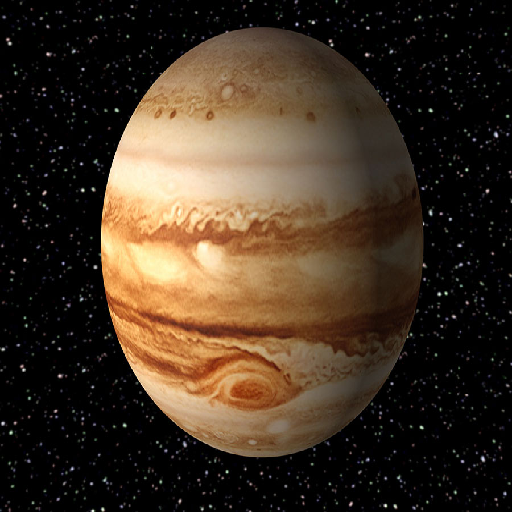

In [8]:
content_path='./Desktop/content.jpg'
content=Image.open(content_path)
content=content.resize((height,width))
content

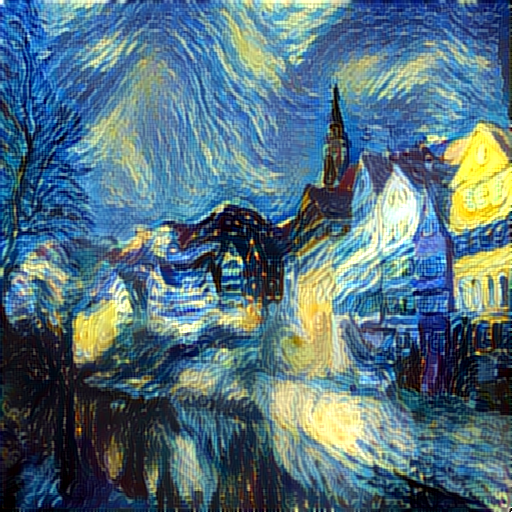

In [7]:
style_path='./Desktop/style.jpg'
style=Image.open(style_path)
style=style.resize((height,width))
style

In [10]:
content_array=np.asarray(content,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
print(content_array.shape)

style_array=np.asarray(style,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [11]:
mean=np.array([123.68, 116.779, 103.939]).reshape(1,1,1,3)

In [15]:
content_array-=mean
content_array=content_array[:,:,:,::-1]

style_array-=mean
style_array=style_array[:,:,:,::-1]

In [16]:
content_image=k.variable(content_array)
style_image=k.variable(style_array)
combination_image=k.placeholder((1,height,width,3))

In [17]:
input_tensor=k.concatenate([content_image,style_image,combination_image],axis=0)

In [46]:
input_tensor

<tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>

In [19]:
model=VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)

In [23]:
layers=dict([(layer.name,layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [24]:
content_weight=0.025
style_weight=5.0
total_variation_weight=1.0

In [25]:
loss=k.variable(0.)

In [27]:
def content_loss(content,combination):
    return k.sum(k.square(content-combination))

layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_image_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_image_features)

In [51]:
def gram_matrix(x):
    nx,ny,nc=x.get_shape().as_list()
    x=tf.reshape(x,[nx*ny,nc])
    return k.dot(x,k.transpose(x))

In [52]:
def style_cost(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height*width
    return k.sum(k.square(S-C))/(4.0 * channels**2 * size**2)

feature_layers=['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer in feature_layers:
    feature_layer=layers[layer]
    style_image_features=feature_layer[1,:,:,:]
    combination_image_features=feature_layer[2,:,:,:]
    sc=style_cost(style_image_features,combination_image_features)
    loss=loss+(style_weight/len(feature_layers))*sc

In [55]:
def total_variation_loss(x):
    a = k.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = k.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return k.sum(k.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [56]:
grads=k.gradients(loss,combination_image)

In [58]:
outputs = [loss]
outputs += grads
f_outputs = k.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [59]:
x=np.random.uniform(0,255,(1,height,width,3))-128

In [1]:
iterations=10
for i in range(iterations):
    print("start of iteration ",i)
    start_time=time.time()
    x,min_val,info=fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

start of iteration  0


NameError: name 'time' is not defined